In [2]:
import os
import pickle

from datasets import load_dataset, Dataset, DatasetDict
from diffusers.pipelines import ScoreSdeVePipeline
import torch
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from mvp_score_modelling.utils import (crop,resize, plt_img)
from mvp_score_modelling.pipelines.utils import VeTweedie
from matplotlib import pyplot as plt
from PIL.Image import Image
from mvp_score_modelling.pipelines.inpainting import MaskGenerator
from mvp_score_modelling.utils import tensor_to_PIL, plt_img

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
FIGURES_DIRECTORY = '../figures/'

lpips = LearnedPerceptualImagePatchSimilarity().to(DEVICE)
def lpips_eval(img, reference):
    return round(lpips(reference, img.to(DEVICE)).item(), 4)

ssim = StructuralSimilarityIndexMeasure().to(DEVICE)
def ssim_eval(img, reference):
    return round(ssim(reference, img.to(DEVICE)).item(), 4)

psnr = PeakSignalNoiseRatio().to(DEVICE)
def psnr_eval(img, reference):
    return round(psnr(reference, img.to(DEVICE)).item(), 4)

In [3]:
# PRETRAINED = "google/ncsnpp-celebahq-256"
PRETRAINED = "google/ncsnpp-church-256"
# EVAL_IMAGE = "data/test_celebhq.png"
EVAL_IMAGE = "data/church/1.png"

eval_img = crop(resize(read_image(EVAL_IMAGE))) / 256
eval_img = eval_img.to(DEVICE)

unconditional_pipeline: ScoreSdeVePipeline = ScoreSdeVePipeline.from_pretrained(PRETRAINED).to(device=DEVICE)
tweedie = VeTweedie(unconditional_pipeline.unet)
sigma = unconditional_pipeline.scheduler.sigmas[800]
z = torch.randn_like(eval_img) * sigma
noised_eval_image = eval_img + z


diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]


# Generate Qualitative Sample Images

In [ ]:
# Loading ground truth

# DATASET_SOURCE = "Ryan-sjtu/celebahq-caption"
DATASET_SOURCE = "tglcourse/lsun_church_train"
#STORE_LOCATION = 'data/celeb'
STORE_LOCATION = 'data/church'

dataset: Dataset = load_dataset(DATASET_SOURCE)['train']

idxs = [1,10,100,1000,10000]
for i in idxs:
    image: Image = dataset[i]['image']
    image.save(os.path.join(STORE_LOCATION, f"{i}.png"))

In [105]:
# Utils
def run_pipelines(y, pipelines, unet, scheduler, inference_steps = 1000):
    images = []
    for p_class in pipelines:
        pipeline = p_class(unet, scheduler)
        img = pipeline(
            y,
            num_inference_steps=inference_steps,
            output_type=None
        )[0]
        images.append(img)
    return images

In [ ]:
# Random mask
from mvp_score_modelling.pipelines.inpainting import (
    PrYtGuidedInpaintingPipeline,
    InpaintingProjectionPipeline,
    ManifoldConstrainedGradientInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline
)

pipelines = [
    InpaintingProjectionPipeline,
    PrYtGuidedInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
]
torch.manual_seed(0)

mask_gen = MaskGenerator((1,3,256,256), device=DEVICE)
random_mask = mask_gen.generate_random_mask()

# random_mask_image = read_image('data/celeb/1.png')
random_mask_image = read_image('data/church/1.png')
random_mask_image = crop(resize(random_mask_image)) / 256
random_mask_image = random_mask_image.to(DEVICE)

random_mask_results = run_pipelines(
    (random_mask_image.unsqueeze(0) , random_mask),
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler,
    inference_steps=1000
)

with open("../output/test_images/church_random_mask_results.pkl", 'wb') as f:
    pickle.dump(random_mask_results, f)
    # random_mask_results = pickle.load(f)

display(*[tensor_to_PIL(img) for img in random_mask_results])

In [ ]:
# Box Mask
torch.manual_seed(0)
pipelines = [
    InpaintingProjectionPipeline,
    PrYtGuidedInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
]

box_mask = mask_gen.generate_box_mask(size= 80)

box_mask_image = read_image('data/church/1000.png')
box_mask_image = crop(resize(box_mask_image)) / 256
box_mask_image = box_mask_image.to(DEVICE)

box_mask_results = run_pipelines(
    (box_mask_image.unsqueeze(0) , box_mask),
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler,
    inference_steps=1000
)

with open("../output/test_images/church_box_mask_results.pkl", 'wb') as f:
    pickle.dump(box_mask_results, f)
    #box_mask_results = pickle.load(f)

display(*[tensor_to_PIL(img) for img in box_mask_results])

In [ ]:
# Box Mask
torch.manual_seed(0)
pipelines = [
    InpaintingProjectionPipeline,
    PrYtGuidedInpaintingPipeline,
    PseudoinverseGuidedInpaintingPipeline,
    ManifoldConstrainedGradientInpaintingPipeline
]

box_mask_2 = mask_gen.generate_box_mask(size= 80)
box_mask_2 = 1 - box_mask_2
box_mask_image_2 = read_image('data/church/10000.png')
box_mask_image_2 = crop(resize(box_mask_image_2)) / 256
box_mask_image_2 = box_mask_image_2.to(DEVICE)

box_mask_results_2 = run_pipelines(
    (box_mask_image_2.unsqueeze(0) , box_mask_2),
    pipelines,
    unconditional_pipeline.unet,
    unconditional_pipeline.scheduler,
    inference_steps=1000
)

with open("../output/test_images/church_box_mask_results_2.pkl", 'wb') as f:
    pickle.dump(box_mask_results_2, f)
    #box_mask_results_2 = pickle.load(f)

display(*[tensor_to_PIL(img) for img in box_mask_results_2])

In [ ]:
# Super resolution
from mvp_score_modelling.pipelines.super_resolution import (
    SuperResolutionProjectionPipeline,
    PrYtGuidedSuperResolutionPipeline,
    PseudoinverseGuidedSuperResolutionPipeline,
    ManifoldConstrainedGradientSuperResolutionPipeline
)

pipelines = [
    SuperResolutionProjectionPipeline,
    PrYtGuidedSuperResolutionPipeline,
    PseudoinverseGuidedSuperResolutionPipeline,
    ManifoldConstrainedGradientSuperResolutionPipeline
]
torch.manual_seed(0)

KERNEL_SIZE = 16
pool = torch.nn.AvgPool2d(kernel_size=KERNEL_SIZE, stride=KERNEL_SIZE)

super_resolution_image = read_image('data/celeb/1.png')
super_resolution_image = crop(resize(super_resolution_image)) / 256
super_resolution_image =super_resolution_image.to(DEVICE)


super_resolution_results = run_pipelines(
    y = (pool(super_resolution_image), KERNEL_SIZE),
    pipelines = pipelines,
    unet=unconditional_pipeline.unet,
    scheduler=unconditional_pipeline.scheduler
)

with open("../output/test_images/celeb_super_resolution_wrong.pkl", 'wb') as f:
    pickle.dump(super_resolution_results, f)
    # random_mask_results = pickle.load(f)

display(*[tensor_to_PIL(img) for img in super_resolution_results])

In [ ]:
# Colorisation
from mvp_score_modelling.pipelines.colorisation import (
    ColorisationProjectionPipeline,
    PrYtGuidedColorisationPipeline,
    ManifoldConstrainedGradientColorisationPipeline,
    PseudoinverseGuidedColorisationPipeline,
    greyscale
)
pipelines = [
    ColorisationProjectionPipeline,
    PrYtGuidedColorisationPipeline,
    PseudoinverseGuidedColorisationPipeline,
    ManifoldConstrainedGradientColorisationPipeline
]
torch.manual_seed(0)


colorisation_image = read_image('data/church/10.png')
colorisation_image = crop(resize(colorisation_image)) / 256
colorisation_image = colorisation_image.to(DEVICE)
grey = greyscale(colorisation_image)

colorisation_results = run_pipelines(
    y = grey,
    pipelines = pipelines,
    unet=unconditional_pipeline.unet,
    scheduler=unconditional_pipeline.scheduler
)

with open("../output/test_images/church_colorisation_results.pkl", 'wb') as f:
    pickle.dump(colorisation_results, f)
    # random_mask_results = pickle.load(f)

display(*[tensor_to_PIL(img) for img in colorisation_results])

32.1335
25.9531
34.3058
26.3181


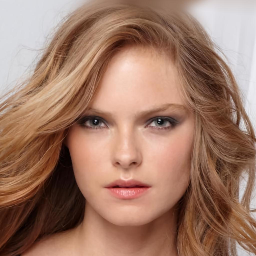

In [43]:
ground_truth = crop(resize(read_image("data/church/10.png"))) / 256
ground_truth = ground_truth.to(DEVICE)
with open("../output/test_images/church_colorisation_results.pkl", 'rb') as f:
    data = pickle.load(f)
for d in data:
    d = d.to(DEVICE)
    print(psnr_eval(d, ground_truth))

display(tensor_to_PIL(ground_truth))

In [ ]:
# Visualising all together

fig, axs = plt.subplots(5,6)
fig.set_size_inches(14,12)

for column in axs:
    for ax in column:
        ax.axis('off')

upscale = SuperResolutionProjectionPipeline.upscale

data = [
    (random_mask_image, lambda x: x * random_mask, random_mask_results),
    (box_mask_image, lambda x: x * box_mask, box_mask_results),
    (box_mask_image_2, lambda x: x * box_mask_2, box_mask_results_2),
    (super_resolution_image, lambda x: upscale(pool(x), KERNEL_SIZE), super_resolution_results),
    (colorisation_image, lambda x: greyscale(x) , colorisation_results)
]

axs[0][0].set_title("Ground Truth")
axs[0][1].set_title("Measurement Y")
axs[0][2].set_title("Constraint")
axs[0][3].set_title("PrYt")
axs[0][4].set_title("Pseudoinverse")
axs[0][5].set_title("MCG")

for i, d in enumerate(data):
    f = d[1]
    plt_img(axs[i][0], d[0])
    plt_img(axs[i][1], d[1](d[0]))
    axs[i][1].text(0,290,"lpips / ssim / y_mse")

    for j, img in enumerate(d[2]):
        plt_img(axs[i][j+2], img)

        lpips_ = lpips_eval(img.unsqueeze(0), d[0].unsqueeze(0))
        ssim_ = ssim_eval(img.unsqueeze(0), d[0].unsqueeze(0))
        mse = ((d[1](d[0]) - d[1](img))**2).mean()

        axs[i][j+2].text(0,290, f"{lpips_:.3g}/{ssim_:.3g}/{mse:.3g}")

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig(os.path.join(FIGURES_DIRECTORY, "visualise-church.png"),bbox_inches='tight', transparent="True", pad_inches=0)

# Tweedie

In [ ]:
# Tweedie

fig, axs = plt.subplots(1,3)
for ax in axs:
    ax.axis('off')

axs[0].set_title("Original")
axs[0].text(0,300,"lpips")
axs[0].text(0,340,"ssim")
plt_img(axs[0], eval_img)

axs[1].set_title(f"Noise Clipped (σ {round(sigma.item(), 3)})")
axs[1].text(0,300,lpips_eval(noised_eval_image.unsqueeze(0).clamp(0,1), eval_img.unsqueeze(0)))
axs[1].text(0,340,ssim_eval(noised_eval_image.unsqueeze(0).clamp(0,1), eval_img.unsqueeze(0)))
plt_img(axs[1], noised_eval_image)

axs[2].set_title("Tweedie")
tw = tweedie(noised_eval_image, sigma)
axs[2].text(0,300,lpips_eval(tw, eval_img.unsqueeze(0)))
axs[2].text(0,340,ssim_eval(tw, eval_img.unsqueeze(0)))
plt_img(axs[2], tw.squeeze())


plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig(os.path.join(FIGURES_DIRECTORY, "tweedie.png"),bbox_inches='tight', transparent="True", pad_inches=0)


# Sigma and Noise

/home/markhaoxiang/Projects/mvp/venv311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


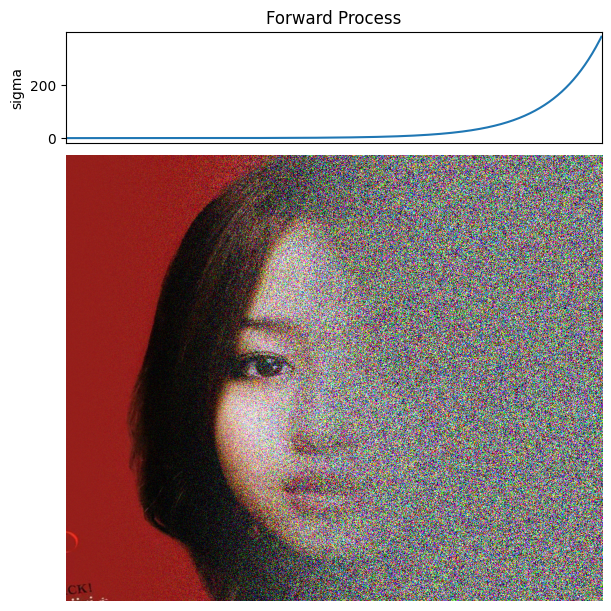

In [99]:
from torchvision.transforms import Resize
unconditional_pipeline.scheduler.set_timesteps(1000)
unconditional_pipeline.scheduler.set_sigmas(1000)
sigmas = unconditional_pipeline.scheduler.sigmas.detach().cpu().numpy()

re1000 = Resize(1000)
sigma_image = re1000(read_image('data/celeb/1.png') / 256)
z = torch.randn_like(sigma_image)
sigmas = sigmas[::-1]
for i in range(1000):
    z[0][i] = z[0][i] * sigmas[i]
    z[1][i] = z[1][i] * sigmas[i]
    z[2][i] = z[2][i] * sigmas[i]
z = z.transpose(-1,-2)
sigma_image += z
sigma_image = sigma_image.clip(0,1)

fig = plt.figure(figsize=(6,6), constrained_layout=True)
gs = fig.add_gridspec(2,1, height_ratios=(1,4))

ax_img = fig.add_subplot(gs[1,0])
ax_graph = fig.add_subplot(gs[0,0])


ax_img.axis('off')
ax_img.set_aspect('auto')
plt_img(ax_img, sigma_image)
ax_graph.plot(sigmas)
ax_img.set_aspect('auto')

ax_graph.sharex(ax_img)
ax_img.sharex(ax_graph)

ax_graph.set_title("Forward Process")
ax_graph.set_ylabel("sigma")
ax_graph.xaxis.set_visible(False)

fig.savefig(os.path.join("../figures/noise.png"), bbox_inches='tight', transparent="True", pad_inches=0.1)
